# SWM mean MPC across subjects

### Libraries

In [1]:
import os
import sys
import glob
import nibabel as nb
import numpy as np
import scipy as sp
import scipy.stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.gradient.utils import dominant_set
from brainspace.mesh.mesh_creation import build_polydata
from brainstat.datasets import fetch_mask
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import copy
import cmocean

### Load surfaces and masks

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)
# Labels and boolean mask
mask_surf = mask_5k != 0

# Load fsLR 5k
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

### Load intensity profiles

In [3]:
T1map_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_T1map_swmIP.npy') # T1 map SWM intensity profiles
MTSAT_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_MTsatnew_swmIP.npy') # MTsat SWM intensity profiles

### Functions

## F1: MPC calculation

In [4]:
# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return (MPCgm, grad)

def _build_kernel(x, kernel, gamma=None):

    if kernel in {'pearson', 'spearman'}:
        if kernel == 'spearman':
            x = np.apply_along_axis(rankdata, 1, x)
        return np.corrcoef(x)

    if kernel in {'cosine', 'normalized_angle'}:
        x = 1 - squareform(pdist(x, metric='cosine'))
        if kernel == 'normalized_angle':
            x = 1 - np.arccos(x, x)/np.pi
        return x

    if kernel == 'gaussian':
        if gamma is None:
            gamma = 1 / x.shape[1]
        return rbf_kernel(x, gamma=gamma)

    if callable(kernel):
        return kernel(x)

    raise ValueError("Unknown kernel '{0}'.".format(kernel))

def compute_affinity(x, kernel=None, sparsity=.9, pre_sparsify=True,
                     non_negative=True, gamma=None):
    """Compute affinity matrix.

    Parameters
    ----------
    x : ndarray, shape = (n_samples, n_feat)
        Input matrix.
    kernel : str, None or callable, optional
        Kernel function. If None, only sparsify. Default is None.
        Valid options:

        - If 'pearson', use Pearson's correlation coefficient.
        - If 'spearman', use Spearman's rank correlation coefficient.
        - If 'cosine', use cosine similarity.
        - If 'normalized_angle': use normalized angle between two vectors. This
          option is based on cosine similarity but provides similarities
          bounded between 0 and 1.
        - If 'gaussian', use Gaussian kernel or RBF.

    sparsity : float or None, optional
        Proportion of smallest elements to zero-out for each row.
        If None, do not sparsify. Default is 0.9.
    pre_sparsify : bool, optional
        Sparsify prior to building the affinity. If False, sparsify the final
        affinity matrix.
    non_negative : bool, optional
        If True, zero-out negative values. Otherwise, do nothing.
    gamma : float or None, optional
        Inverse kernel width. Only used if ``kernel == 'gaussian'``.
        If None, ``gamma = 1./n_feat``. Default is None.

    Returns
    -------
    affinity : ndarray, shape = (n_samples, n_samples)
        Affinity matrix.
    """

    # Do not accept sparse matrices for now
    if sp.issparse(x):
        x = x.toarray()

    if not pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if sparsity is not None and sparsity > 0:
        x = dominant_set(x, k=1-sparsity, is_thresh=False, as_sparse=False)

    if pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if non_negative:
        x[x < 0] = 0

    return x

## MPC - T1 map

In [5]:
MPC_T1map = build_mpc(T1map_swm_int, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_T1map = mpc_dm(MPC_T1map, mask_surf, Ngrad=Ngrad, kernel=None, sparsity=0.95)

/tmp/ipykernel_281160/3195170674.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


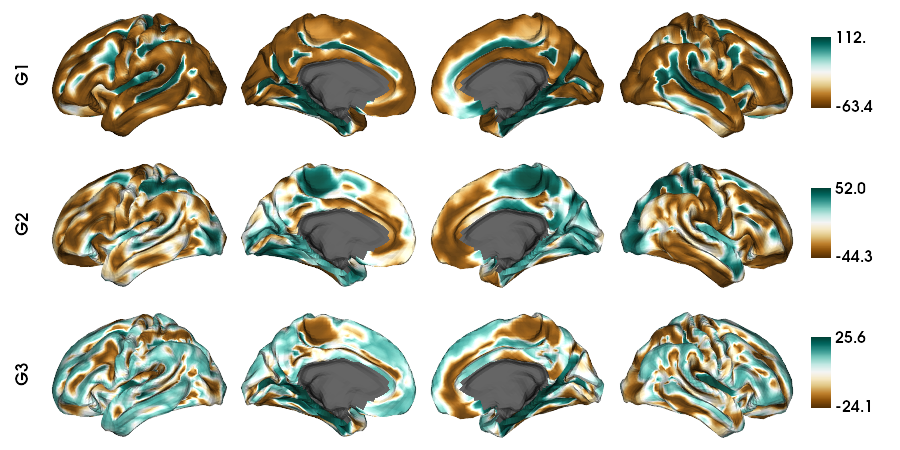

In [6]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=grad_T1map, cmap='BrBG', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

## MPC - MTsat

In [7]:
MPC_MTSAT = build_mpc(MTSAT_swm_int, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_MTSAT = mpc_dm(MPC_MTSAT, mask_surf, Ngrad=Ngrad, kernel=None, sparsity=0.95)

/tmp/ipykernel_281160/3195170674.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


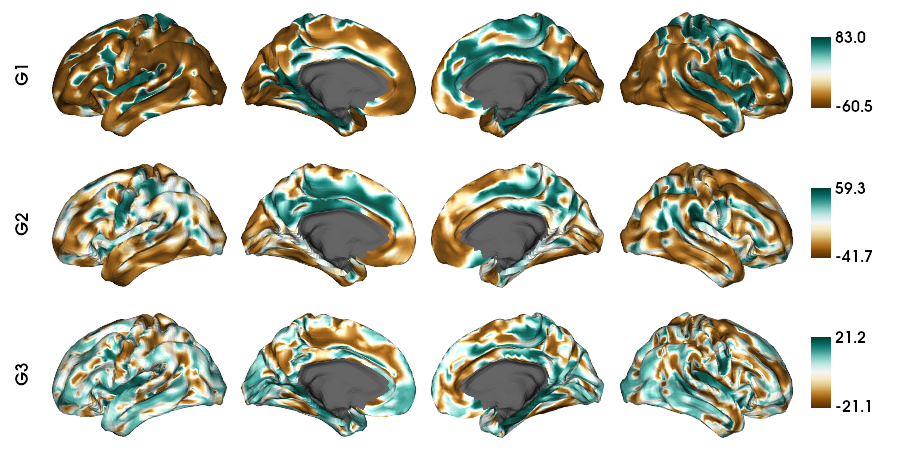

In [8]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=grad_MTSAT, cmap='BrBG', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)